# Курсовой проект

## Задание
**Построение модели классификации**  
1. Обзор обучающего датасета  
2. Обработка выбросов  
3. Обработка пропусков  
4. Анализ данных  
5. Отбор признаков  
6. Балансировка классов  
7. Подбор моделей, получение бейзлана  
8. Выбор наилучшей модели, настройка гиперпараметров  
9. Проверка качества, борьба с переобучением  
10. Интерпретация результатов  

**Прогнозирование на тестовом датасете**  
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков  
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете  
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)  
4. Соблюдать исходный порядок примеров из тестового датасета  

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)


### Импорт библиотек

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import catboost as catb

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt


def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))


def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

### Решение

**Указываем пути к файлам с выборками**

In [170]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

**Загружаем данные**

In [171]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_train = pd.read_csv(TRAIN_DATASET_PATH)

## Обзор и обработка обучающего датасета

**Смотрим количество данных**

In [172]:
df_train.shape

(7500, 17)

**Смотрим типы данных по столбцам**

In [173]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

*Видим столбцы со значением NaN (Years in current job, Months since last delinquent), в которых должны находиться числа.*

**Создаем константы с названиями столбцов (для удобства)**

In [174]:
HOME_OWNERSHIP='Home Ownership'
ANNUAL_INCOME='Annual Income'
YEARS_IN_CURRENT_JOB='Years in current job'
TAX_LIENS='Tax Liens'
NUMBER_OF_OPEN_ACCOUNTS='Number of Open Accounts'
YEARS_OF_CREDIT_HISTORY='Years of Credit History'
MAXIMUM_OPEN_CREDIT='Maximum Open Credit'
NUMBER_OF_CREDIT_PROBLEMS='Number of Credit Problems'
MONTHS_SINCE_LAST_DELINQUENT='Months since last delinquent'
BANKRUPTCIES='Bankruptcies'
PURPOSE='Purpose'
TERM='Term'
CURRENT_LOAN_AMOUNT='Current Loan Amount'
CURRENT_CREDIT_BALANCE='Current Credit Balance'
MONTHLY_DEBT='Monthly Debt'
CREDIT_SCORE='Credit Score'
CREDIT_DEFAULT='Credit Default'

**Смотрим содержимое**

In [175]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [176]:
df_train.isna().sum(axis=0)

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [177]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


*Наблюдаем*
- *Current Loan Amount содержит выбросы - 99999999, заменить на среднее*
- *Home Ownership является категориальным признаком - нужно превратить в dummies*
- *Annual Income: NaN заменить модой/средним*
- *Years in current job является числовым признаком - нужно превратить значения, вроде NaN и 10+ в моду/ноль и удалить везде слово 'years'*
- *Months since last delinquent - нужно NaN заменить на 0*
- *Purpose,Term превратить в dummies*
- *Credit Score: NaN заменить средним/нулем*
- *Bankruptcies: NaN заменить нулем*
- *Credit Score часть значений в пределах 1000, часть в пределах 10000: привести все к пределу 1000*

**Пишем функцию обработки**

In [178]:
def process_data(dataframe):
    new_dataframe = dataframe.copy()

    # Заменим на среднее Current Load Amount == 99999999.0
    outlier_value = 99999999.0
    temp_df = new_dataframe[new_dataframe[CURRENT_LOAN_AMOUNT] < outlier_value]
    new_dataframe.loc[new_dataframe[CURRENT_LOAN_AMOUNT] == outlier_value, CURRENT_LOAN_AMOUNT] = temp_df[CURRENT_LOAN_AMOUNT].mean()
    
    # Заменяем ANNUAL_INCOME на среднее по выборке
    new_dataframe.loc[new_dataframe[ANNUAL_INCOME].isna(), ANNUAL_INCOME] = new_dataframe[ANNUAL_INCOME].mean()
    
    # Обрабатываем YEARS_IN_CURRENT_JOB
    # - Сначала вырезаем из имеющихся значений все, что не является цифрой
    new_dataframe[YEARS_IN_CURRENT_JOB].replace(to_replace=r'[^\d]+', value='', inplace=True, regex=True)
    # - Заменяем все NaN на '0'
    new_dataframe.loc[new_dataframe[YEARS_IN_CURRENT_JOB].isna() == True, YEARS_IN_CURRENT_JOB] = '999'
    # - Меняем тип столбца на int
    new_dataframe[YEARS_IN_CURRENT_JOB] = new_dataframe[YEARS_IN_CURRENT_JOB].astype(int)
    # - Заменяем все 0 на среднее значение
    new_dataframe.loc[new_dataframe[YEARS_IN_CURRENT_JOB] == 999, YEARS_IN_CURRENT_JOB] = int(new_dataframe[YEARS_IN_CURRENT_JOB].mean())
    
    # Заменяем MONTHS_SINCE_LAST_DELINQUENT на 0
    new_dataframe.loc[new_dataframe[MONTHS_SINCE_LAST_DELINQUENT].isna() == True, MONTHS_SINCE_LAST_DELINQUENT] = 0
    
    # Заменяем Purpose, Home Ownership на dummy признаки
    new_dataframe[PURPOSE] = new_dataframe[PURPOSE].astype("category")
    new_dataframe[HOME_OWNERSHIP] = new_dataframe[HOME_OWNERSHIP].astype("category")
    new_dataframe = pd.get_dummies(new_dataframe, columns=[HOME_OWNERSHIP, PURPOSE])
    
    # Заменяем Term на int
    new_dataframe.loc[new_dataframe[TERM] == 'Short Term', TERM] = '0'
    new_dataframe.loc[new_dataframe[TERM] == 'Long Term', TERM] = '1'
    new_dataframe[TERM] = new_dataframe[TERM].astype("int8")
    
    # Заменяем все NaN в Bankruptcies на 0
    new_dataframe.loc[new_dataframe[BANKRUPTCIES].isna() == True, BANKRUPTCIES] = 0

    return new_dataframe

**Обрабатываем train_dataframe**

In [179]:
df_train = process_data(df_train)
df_train.dtypes

NameError: name 'CURRENT_LOAD_AMOUNT' is not defined

## Анализируем данные

In [150]:
df_train.corr()

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
Annual Income,1.000000e+00,-0.430717,-4.249194e-01,-0.424912,-0.424910,0.021219,-4.249196e-01,-0.424918,-4.249197e-01,-0.420984,...,0.073605,0.015206,0.036026,-0.005426,0.025756,2.358940e-18,-0.006208,-0.002344,0.006111,0.035877
Years in current job,-4.307173e-01,1.000000,9.972297e-01,0.997230,0.997231,-0.013256,9.972298e-01,0.997230,9.972297e-01,0.996221,...,-0.077951,-0.025327,-0.033852,-0.012397,-0.103533,-6.195471e-03,-0.020163,-0.024156,-0.011596,-0.015187
Tax Liens,-4.249194e-01,0.997230,1.000000e+00,1.000000,1.000000,-0.013006,1.000000e+00,1.000000,1.000000e+00,0.999154,...,-0.080146,-0.025506,-0.033341,-0.011837,-0.106724,-5.916236e-03,-0.020091,-0.024445,-0.011072,-0.014501
Number of Open Accounts,-4.249125e-01,0.997230,1.000000e+00,1.000000,1.000000,-0.013005,1.000000e+00,1.000000,1.000000e+00,0.999154,...,-0.080146,-0.025506,-0.033341,-0.011838,-0.106727,-5.916665e-03,-0.020091,-0.024447,-0.011071,-0.014502
Years of Credit History,-4.249099e-01,0.997231,1.000000e+00,1.000000,1.000000,-0.013004,1.000000e+00,1.000000,1.000000e+00,0.999154,...,-0.080144,-0.025507,-0.033339,-0.011838,-0.106724,-5.915083e-03,-0.020092,-0.024447,-0.011072,-0.014502
Maximum Open Credit,2.121902e-02,-0.013256,-1.300603e-02,-0.013005,-0.013004,1.000000,-1.300605e-02,-0.013008,-1.300607e-02,-0.013305,...,-0.000561,-0.001551,-0.002181,-0.001277,0.004093,-6.581684e-04,-0.001904,0.044833,-0.001100,-0.000710
Number of Credit Problems,-4.249196e-01,0.997230,1.000000e+00,1.000000,1.000000,-0.013006,1.000000e+00,1.000000,1.000000e+00,0.999154,...,-0.080146,-0.025506,-0.033341,-0.011837,-0.106724,-5.916260e-03,-0.020091,-0.024445,-0.011072,-0.014501
Months since last delinquent,-4.249182e-01,0.997230,1.000000e+00,1.000000,1.000000,-0.013008,1.000000e+00,1.000000,1.000000e+00,0.999154,...,-0.080145,-0.025509,-0.033338,-0.011838,-0.106726,-5.916800e-03,-0.020091,-0.024445,-0.011065,-0.014501
Bankruptcies,-4.249197e-01,0.997230,1.000000e+00,1.000000,1.000000,-0.013006,1.000000e+00,1.000000,1.000000e+00,0.999154,...,-0.080146,-0.025506,-0.033341,-0.011837,-0.106724,-5.916251e-03,-0.020091,-0.024445,-0.011072,-0.014501
Term,-4.209844e-01,0.996221,9.991542e-01,0.999154,0.999154,-0.013305,9.991542e-01,0.999154,9.991542e-01,1.000000,...,-0.078712,-0.025306,-0.033615,-0.012298,-0.108405,-5.544225e-03,-0.019183,-0.025641,-0.011449,-0.014574


In [151]:
TARGET_NAME = CREDIT_DEFAULT
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

In [180]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

*Наблюдаем преобладание числа объектов класса 0 над числом объектов класса 1  
=> классы несбалансированы  
=> требуется балансировка*

**Построим гистограмму корреляции признаков с целевым признаком**

In [181]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

KeyError: "['Purpose_medical bills', 'Purpose_vacation', 'Purpose_buy a car', 'Purpose_wedding', 'Purpose_309024.390346908', 'Purpose_business loan', 'Purpose_buy house', 'Home Ownership_Own Home', 'Home Ownership_Rent', 'Purpose_renewable energy', 'Purpose_take a trip', 'Home Ownership_Have Mortgage', 'Purpose_small business', 'Home Ownership_Home Mortgage', 'Purpose_educational expenses', 'Purpose_moving', 'Purpose_other', 'Purpose_home improvements', 'Purpose_major purchase', 'Home Ownership_309024.390346908', 'Purpose_debt consolidation'] not in index"

*Наблюдаем наиболее значимые признаки: Credit Score, Current Loan Amount, Annual Income, Term, Home Ownership_Rent, Home Ownership_Home Mortgage*

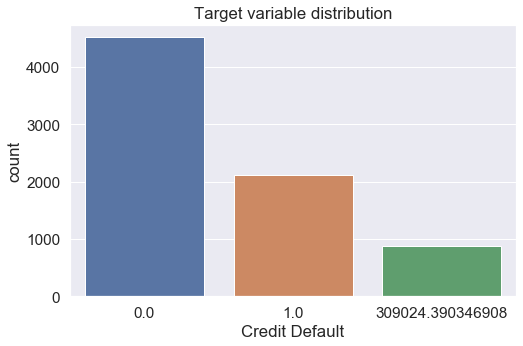

In [154]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

*Наблюдаем, несбалансированность классов в исходной выборке => потребуется балансировка*

**Посмотрим на матрицу корреляций**

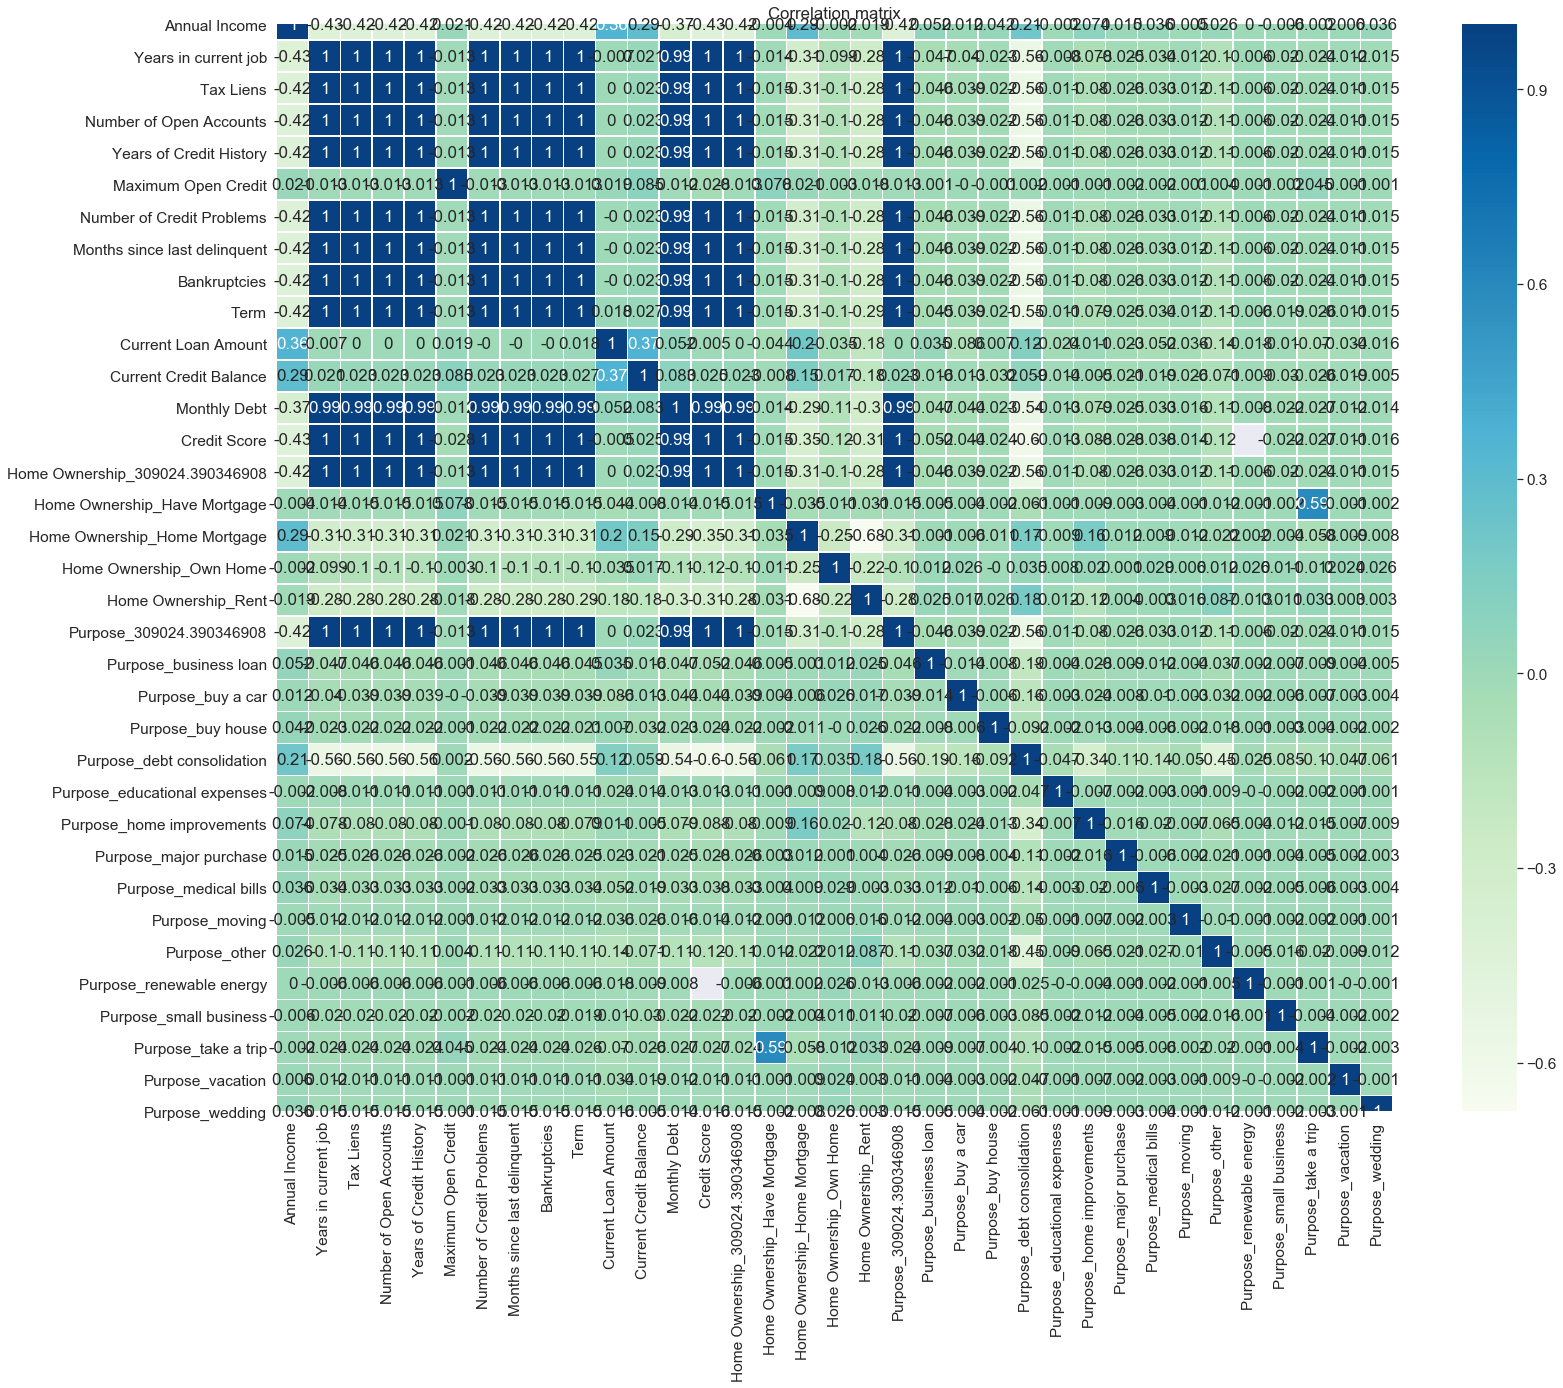

In [155]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

*Высокая корреляция наблюдается между признаками Bankruptcies, Number of Credit Problems, что логично, но Bankruptcies практически не коррелирует с целевой переменной, можно его исключить*

## Отбор признаков

In [156]:
df_train.dtypes

Annual Income                      float64
Years in current job                 int64
Tax Liens                          float64
Number of Open Accounts            float64
Years of Credit History            float64
Maximum Open Credit                float64
Number of Credit Problems          float64
Months since last delinquent       float64
Bankruptcies                       float64
Term                                  int8
Current Loan Amount                float64
Current Credit Balance             float64
Monthly Debt                       float64
Credit Score                       float64
Credit Default                     float64
Home Ownership_309024.390346908      uint8
Home Ownership_Have Mortgage         uint8
Home Ownership_Home Mortgage         uint8
Home Ownership_Own Home              uint8
Home Ownership_Rent                  uint8
Purpose_309024.390346908             uint8
Purpose_business loan                uint8
Purpose_buy a car                    uint8
Purpose_buy

In [157]:
# В ходе проведенного анализа были выявлены следующие значимые признаки:
# Credit Score, Current Loan Amount, Annual Income, Term, Home Ownership_Rent, Home Ownership_Home Mortgage
SELECTED_FEATURE_NAMES = [
    CREDIT_SCORE,
    CURRENT_LOADN_AMOUNT, 
    ANNUAL_INCOME, 
    TERM, 
    'Home Ownership_Rent', 
    'Home Ownership_Home Mortgage',
    'Purpose_small business',
    'Number of Open Accounts',
    'Purpose_renewable energy',
    'Tax Liens',
    'Number of Credit Problems',
    'Monthly Debt',
    'Years of Credit History',
    'Current Credit Balance',
    'Purpose_debt consolidation',
    'Purpose_educational expenses'
]

NUM_FEATURE_NAMES = [
    ANNUAL_INCOME,
    YEARS_IN_CURRENT_JOB,
    TAX_LIENS, 
    NUMBER_OF_OPEN_ACCOUNTS,
    YEARS_OF_CREDIT_HISTORY,
    MAXIMUM_OPEN_CREDIT,
    NUMBER_OF_CREDIT_PROBLEMS,
    MONTHS_SINCE_LAST_DELINQUENT,
    BANKRUPTCIES,
    TERM,
    CURRENT_LOADN_AMOUNT,
    CURRENT_CREDIT_BALANCE,
    MONTHLY_DEBT,
    CREDIT_SCORE
]

## Нормализуем данные

In [158]:
def normalize_dataframe(dataframe, numeric_feature_names):
    scaler = StandardScaler()

    df_norm = dataframe.copy()
    df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

    return df_norm

In [159]:
df_norm = normalize_dataframe(df_train, NUM_FEATURE_NAMES)

In [160]:
df_norm

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-1.173016,2.752912,2.760560,2.760560,2.760560,-0.035904,2.760560,2.760560,2.760560,2.758225,...,0,0,0,0,0,0,0,0,0,0
1,-0.232517,-0.379308,-0.362246,-0.362206,-0.362276,0.018604,-0.362247,-0.362407,-0.362247,-0.290298,...,0,0,0,0,0,0,0,0,0,0
2,-1.173016,2.752912,2.760560,2.760560,2.760560,-0.035904,2.760560,2.760560,2.760560,2.758225,...,0,0,0,0,0,0,0,0,0,0
3,-0.521861,-0.379348,-0.362246,-0.362277,-0.362203,-0.045999,-0.362237,-0.362407,-0.362236,-0.388638,...,0,0,0,0,0,0,0,0,0,0
4,-0.559672,-0.379328,-0.362246,-0.362226,-0.362293,-0.031106,-0.362237,-0.362407,-0.362247,-0.388638,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,-1.050715,-0.379399,-0.362246,-0.362328,-0.362344,-0.048468,-0.362247,-0.362407,-0.362247,-0.388638,...,0,0,0,0,1,0,0,0,0,0
7496,0.434985,-0.379399,-0.362246,-0.362257,-0.362162,-0.012339,-0.362247,-0.361972,-0.362247,-0.290298,...,0,0,0,0,0,0,0,0,0,0
7497,-1.173016,2.752912,2.760560,2.760560,2.760560,-0.035904,2.760560,2.760560,2.760560,2.758225,...,0,0,0,0,0,0,0,0,0,0
7498,0.000000,-0.015571,-0.362246,-0.362146,-0.362162,0.016076,-0.362247,-0.362407,-0.362247,-0.388638,...,0,0,0,0,0,0,0,0,0,0


## Выполним балансировку целевой переменной

In [161]:
df_balanced = balance_df_by_target(df_train, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0.000000         4517
309024.390347    4350
1.000000         2113
Name: Credit Default, dtype: int64

## Обучение модели

Подготовим X_train, y_train, X_test, y_test

In [162]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [163]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
params = {'n_estimators': [50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth': [3, 5, 7]}

cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [164]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CatBoostError: catboost/libs/data/util.h:33: class weights size data size (2) is not equal to class count (3)

In [33]:
rs.best_params_

{'n_estimators': 100, 'max_depth': 3}

In [34]:
rs.best_score_

0.5330228243107148

In [35]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=rs.best_params_['n_estimators'], 
                                      max_depth=rs.best_params_['max_depth'],
                                      silent=True, 
                                      random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3771
           1       0.86      0.31      0.45      1479

    accuracy                           0.79      5250
   macro avg       0.82      0.64      0.66      5250
weighted avg       0.81      0.79      0.75      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1616
           1       0.80      0.28      0.41       634

    accuracy                           0.78      2250
   macro avg       0.79      0.63      0.64      2250
weighted avg       0.78      0.78      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1571   45
1                457  177
CPU times: user 1.67 s, sys: 127 ms, total: 1.8 s
Wall time: 269 ms
